# 2009年上海居民出行调查数据
包含：
* (1)family.csv
* (2)person.csv
* (3)trip.csv

In [276]:
import numpy as np
import pandas as pd
import os
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']

pd.set_option('max_rows',1000)
pd.set_option('max_columns',50)

os.chdir('E:\\zhpy\\2travel_survey_2009SH')

In [2]:
# gender: （1.男 2.女）
# edu: (1.小学以下2.小学 3.初中 4.高中 5.大专6.本科 7.研究生及以上)
# job: （1.单位负责人2.专业技术人员3.办事人员及有关人员4.私营业主及个体经营者|5.农林牧渔水利生产人员6.生产运输设备操作人员
#        7.商业及服务人员8.离退休人员9.离退休再就业人员10.学生11.其它）
# income: (1.无 2.<1000   3.1001-2000 4.2001-3000   5.3001-5000 6.5001-10000  7.>10000)
# Pcharacter: (1.户籍人口  2.非户籍常住3.非户籍流动)
# iftrip: （1.出行  2.不出行）
# ifworkday: （1.工作日2.双休日）
person_cols = ['HomeID','PersonID','age','gender','edu','job','income','Pcharacter','iftrip','ifworkday','Pweight','UNIT_X','UNIT_Y']
person = pd.read_csv('./person.csv',usecols=person_cols)
person.iftrip = person.iftrip.apply(lambda x: x[2:])
person.ifworkday = person.ifworkday.apply(lambda x: x[2:])
person.sort_values(['HomeID','PersonID'],inplace=True)

In [3]:
person.head()

,PersonID,HomeID,age,gender,edu,job,income,Pcharacter,iftrip,ifworkday,Pweight,UNIT_X,UNIT_Y
0,1,1,46,1,3,5,3,1.户籍人口,出行,工作日,89.22,121.020038,30.976588
1,2,1,43,2,3,4,3,1.户籍人口,出行,工作日,72.74,121.020038,30.976588
2,3,2,46,1,3,11,2,1.户籍人口,出行,工作日,235.11,121.467201,31.235452
3,4,2,46,2,3,11,2,1.户籍人口,出行,工作日,179.28,121.467201,31.235452
4,5,2,23,2,5,2,2,1.户籍人口,出行,工作日,99.43,121.467201,31.235452


In [4]:
def time_string_format(t):
    # 将travel中time转换为时间格式
    hm = t.zfill(4)
    hms = hm[:2] + ':' + hm[2:] + ':00'
    return hms

In [5]:
# trip purpose: 1.上班 2.上学 3.购物 4.文化娱乐 5.业务 6.接送人 7.回家8.其它生活
trip_cols = ['HomeID','PersonID','Stime','Etime','Tpurpose','Tduration','Tmode','Tweight','FROM_X','FROM_Y','TO_X','TO_Y']
trip = pd.read_csv('./trip.csv',usecols=trip_cols,dtype={'Stime':str,'Etime':str,'Tpurpose':str})
trip['Stime'] = trip['Stime'].apply(lambda x: time_string_format(x))
trip['Etime'] = trip['Etime'].apply(lambda x: time_string_format(x))
trip.sort_values(['HomeID','PersonID','Stime'],inplace=True)

In [6]:
# 本次出行的目的:1.上班 2.上学 3.购物 4.文化娱乐 5.业务 6.接送人 7.回家8.其它生活
# modes = {'1':'Work', '2':'School', '3':'Shop', '4':'Entertain', '5':'Business', '6':'Take', '7':'Home', '8':'Other'}
modes = {'1':'W', '2':'L', '3':'S', '4':'E', '5':'B', '6':'T', '7':'H', '8':'O'}
trip.Tpurpose = trip.Tpurpose.map(modes)

In [7]:
trip.head()

,PersonID,HomeID,Stime,Etime,Tpurpose,Tmode,Tduration,Tweight,FROM_X,FROM_Y,TO_X,TO_Y
0,1,1,07:50:00,08:00:00,W,3.摩托车,10,376.68,121.467201,31.235452,121.020038,30.976588
1,1,1,11:00:00,11:10:00,H,3.摩托车,10,376.68,121.020038,30.976588,121.467201,31.235452
2,1,1,12:50:00,13:00:00,W,3.摩托车,10,376.68,121.467201,31.235452,121.020038,30.976588
3,1,1,15:30:00,15:40:00,H,3.摩托车,10,376.68,121.020038,30.976588,121.467201,31.235452
4,2,1,07:00:00,07:15:00,W,1.自行车,15,43.36,121.467201,31.235452,121.020038,30.976588


In [9]:
# 出行转换为停驻
t0 = datetime.datetime.now()
user_res = []
for user, userTrip in trip.groupby('PersonID'):
    userTrip.reset_index(drop=True,inplace=True)
    userTrip['TT'] = userTrip.Etime.shift(1)
    homeID = userTrip.HomeID.unique()[0]
    user_res.append([homeID, user, '00:00:00'] + userTrip.loc[0,['Stime','FROM_X','FROM_Y']].values.tolist() + ['H'])
    for i in range(1,len(userTrip)):
        user_res.append([homeID, user] + userTrip.loc[i,['TT','Stime','FROM_X','FROM_Y']].values.tolist() +\
                        [userTrip.loc[i-1,'Tpurpose']])
    user_res.append([homeID, user] + [userTrip.iloc[-1]['Etime']] + ['23:59:59' ] +\
                    userTrip.loc[len(userTrip)-1,['TO_X','TO_Y']].values.tolist() +\
                    [userTrip.loc[len(userTrip)-1,'Tpurpose']])
    if user % 1000 == 0: print(user)
print((datetime.datetime.now() - t0).seconds / 3600)

E:\Anaconda3-5.0.1\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
18000
19000
21000
22000
23000
26000
27000
29000
30000
31000
32000
34000
36000
37000
39000
40000
41000
42000
43000
44000
45000
47000
48000
49000
50000
52000
53000
54000
55000
56000
57000
58000
59000
60000
62000
63000
64000
65000
66000
67000
69000
71000
72000
73000
74000
75000
78000
79000
80000
81000
82000
84000
85000
86000
87000
88000
89000
91000
92000
93000
94000
95000
96000
97000
98000
100000
101000
102000
104000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
124000
125000
126000
127000
128000
129000
131000
132000
133000
134000
135000
137000
138000
2.3627777777777776


In [11]:
stay = pd.DataFrame(user_res,columns=['HomeID','PersonID','Stime','Etime','Slon','Slat','activity'])

In [12]:
stay = pd.merge(stay,person[['PersonID','ifworkday']],left_on='PersonID',right_on='PersonID')

In [13]:
stay.to_csv('./stay.csv',index=False)

In [15]:
stay['Shour'] = stay.Stime.apply(lambda x: int(x[:2]))
stay['Ehour'] = stay.Etime.apply(lambda x: int(x[:2]))

In [86]:
stay.head()

,HomeID,PersonID,Stime,Etime,Slon,Slat,activity,ifworkday,Shour,Ehour
0,1,1,00:00:00,07:50:00,121.467201,31.235452,H,工作日,0,7
1,1,1,08:00:00,11:00:00,121.020038,30.976588,W,工作日,8,11
2,1,1,11:10:00,12:50:00,121.467201,31.235452,H,工作日,11,12
3,1,1,13:00:00,15:30:00,121.020038,30.976588,W,工作日,13,15
4,1,1,15:40:00,23:59:59,121.467201,31.235452,H,工作日,15,23


In [336]:
# 数据中存在error，简单剔除,建立新的数据stop
stop = stay[(stay.Shour<24) & (stay.Ehour<24)]
stop.reset_index(drop=True,inplace=True)

# 活动设置为：H, W, O
stop['activity'] = stop.activity.apply(lambda x: 'O' if x not in ['H','W'] else x)

E:\Anaconda3-5.0.1\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### 时间分布

In [110]:
t1 = datetime.datetime.now()
time_res = []
for i in range(len(stop)):
    for j in range(stop.loc[i,'Shour'],stop.loc[i,'Ehour']+1):
        time_res.append(stop.loc[i,['activity','ifworkday']].values.tolist() + [j])
print((datetime.datetime.now() - t1).seconds / 3600)

0.6183333333333333


In [128]:
res = pd.DataFrame(time_res,columns=['activity','ifworkday','hour'])
res.reset_index(inplace=True)
res = res.groupby(['ifworkday','activity','hour']).index.count().reset_index()
res.rename(columns={'index':'cnt'},inplace=True)

In [131]:
res.head()

,ifworkday,activity,hour,cnt
0,双休日,H,0,30437
1,双休日,H,1,30369
2,双休日,H,2,30337
3,双休日,H,3,30290
4,双休日,H,4,30226


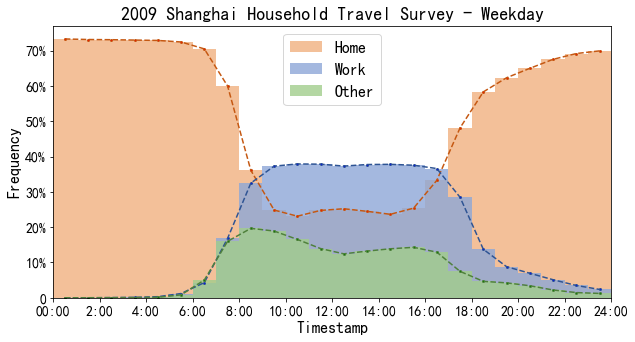

In [294]:
# 绘图
def rgb(R,G,B): return "#%02X%02X%02X" % (R,G,B)

plt.figure(figsize=(10,5))
#plt.subplot(1,2,1)
plt.bar(np.arange(1,25),res.loc[(res.ifworkday=='工作日') & (res.activity=='H'),'cnt'].values/stop.PersonID.nunique(),\
        color=rgb(241,177,128),alpha=0.8,width=1)
plt.bar(np.arange(1,25),res.loc[(res.ifworkday=='工作日') & (res.activity=='W'),'cnt'].values/stop.PersonID.nunique(),\
        color=rgb(141,167,215),alpha=0.8,width=1)
plt.bar(np.arange(1,25),res.loc[(res.ifworkday=='工作日') & (res.activity=='O'),'cnt'].values/stop.PersonID.nunique(),\
        color=rgb(162,205,140),alpha=0.8,width=1)
plt.legend(['Home','Work','Other'],fontsize=16)

plt.plot(np.arange(1,25),res.loc[(res.ifworkday=='工作日') & (res.activity=='H'),'cnt'].values/stop.PersonID.nunique(),\
         color=rgb(197,88,18),linestyle='dashed', marker='o',markerfacecolor='r', markersize=2)
plt.plot(np.arange(1,25),res.loc[(res.ifworkday=='工作日') & (res.activity=='W'),'cnt'].values/stop.PersonID.nunique(),\
         color=rgb(46,84,148),linestyle='dashed', marker='o',markerfacecolor='b', markersize=2)
plt.plot(np.arange(1,25),res.loc[(res.ifworkday=='工作日') & (res.activity=='O'),'cnt'].values/stop.PersonID.nunique(),\
         color=rgb(79,129,60),linestyle='dashed', marker='o',markerfacecolor='g', markersize=2)

plt.xlim([0.5,24.5])
plt.title('2009 Shanghai Household Travel Survey - Weekday',fontsize=18)
plt.xlabel('Timestamp',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.xticks(np.linspace(0.5,24.5,13),['00:00','2:00','4:00','6:00','8:00','10:00','12:00','14:00','16:00','18:00','20:00','22:00','24:00']);
plt.yticks(np.linspace(0,0.7,8),['0','10%','20%','30%','40%','50%','60%','70%'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('C:\\Users\Administrator\Desktop\ztime1.png',bbox_inches='tight',pad_inches=0,dpi=600)

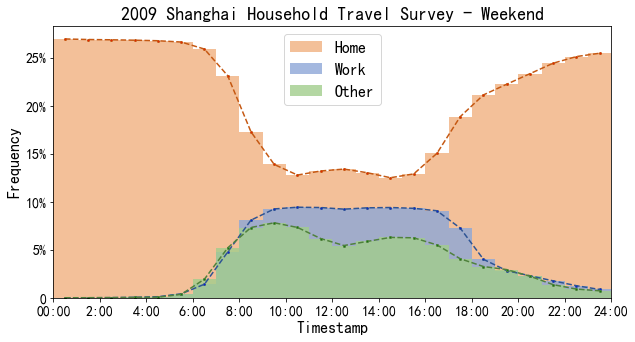

In [295]:
plt.figure(figsize=(10,5))
#plt.subplot(1,2,2)
plt.bar(np.arange(1,25),res.loc[(res.ifworkday=='双休日') & (res.activity=='H'),'cnt'].values/stop.PersonID.nunique(),\
        color=rgb(241,177,128),alpha=0.8,width=1)
plt.bar(np.arange(1,25),res.loc[(res.ifworkday=='双休日') & (res.activity=='W'),'cnt'].values/stop.PersonID.nunique(),\
        color=rgb(141,167,215),alpha=0.8,width=1)
plt.bar(np.arange(1,25),res.loc[(res.ifworkday=='双休日') & (res.activity=='O'),'cnt'].values/stop.PersonID.nunique(),\
        color=rgb(162,205,140),alpha=0.8,width=1)
plt.legend(['Home','Work','Other'],fontsize=16)

plt.plot(np.arange(1,25),res.loc[(res.ifworkday=='双休日') & (res.activity=='H'),'cnt'].values/stop.PersonID.nunique(),\
         color=rgb(197,88,18),linestyle='dashed', marker='o',markerfacecolor='r', markersize=2)
plt.plot(np.arange(1,25),res.loc[(res.ifworkday=='双休日') & (res.activity=='W'),'cnt'].values/stop.PersonID.nunique(),\
         color=rgb(46,84,148),linestyle='dashed', marker='o',markerfacecolor='b', markersize=2)
plt.plot(np.arange(1,25),res.loc[(res.ifworkday=='双休日') & (res.activity=='O'),'cnt'].values/stop.PersonID.nunique(),\
         color=rgb(79,129,60),linestyle='dashed', marker='o',markerfacecolor='g', markersize=2)

plt.xlim([0.5,24.5])
plt.title('2009 Shanghai Household Travel Survey - Weekend',fontsize=18)
plt.xlabel('Timestamp',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.xticks(np.linspace(0.5,24.5,13),['00:00','2:00','4:00','6:00','8:00','10:00','12:00','14:00','16:00','18:00','20:00','22:00','24:00']);
plt.yticks(np.linspace(0,0.25,6),['0','5%','10%','15%','20%','25%'])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('C:\\Users\Administrator\Desktop\ztime.png',bbox_inches='tight',pad_inches=0,dpi=600)

### 时长分布

In [337]:
stop['duration'] = stop[['Stime','Etime']].apply(lambda r: (datetime.datetime.strptime(r.Etime,'%H:%M:%S')\
                        - datetime.datetime.strptime(r.Stime,'%H:%M:%S')).seconds, axis=1)

E:\Anaconda3-5.0.1\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [338]:
stop['d2'] = stop.duration / 60

E:\Anaconda3-5.0.1\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [339]:
stop.head()

,HomeID,PersonID,Stime,Etime,Slon,Slat,activity,ifworkday,Shour,Ehour,duration,d2
0,1,1,00:00:00,07:50:00,121.467201,31.235452,H,工作日,0,7,28200,470.000000
1,1,1,08:00:00,11:00:00,121.020038,30.976588,W,工作日,8,11,10800,180.000000
2,1,1,11:10:00,12:50:00,121.467201,31.235452,H,工作日,11,12,6000,100.000000
3,1,1,13:00:00,15:30:00,121.020038,30.976588,W,工作日,13,15,9000,150.000000
4,1,1,15:40:00,23:59:59,121.467201,31.235452,H,工作日,15,23,29999,499.983333


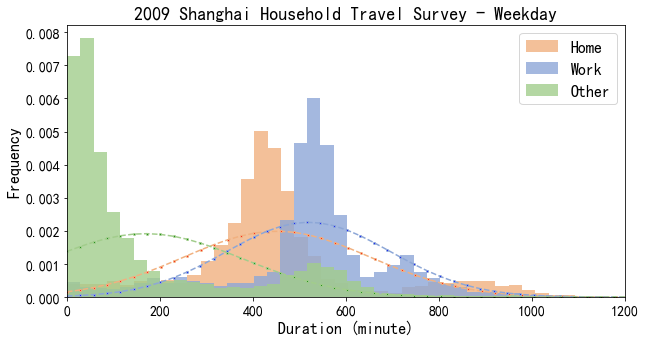

In [340]:
plt.figure(figsize=(10,5))
#plt.subplot(1,2,1)
num_bins = 50
# Home
mu_H, sigma_H = stop.loc[(stop.ifworkday=='工作日')&(stop.activity=='H'),'d2'].agg(['mean','std'])
n, bins, patchs = plt.hist(stop.loc[(stop.ifworkday=='工作日')&(stop.activity=='H'),'d2'],\
                           num_bins, normed=1, color=rgb(241,177,128), alpha=0.8,label='Home')
y_H = mpl.mlab.normpdf(bins,mu_H,sigma_H)
plt.plot(bins,y_H,color=rgb(241,177,128), linestyle='dashed', marker='o', markerfacecolor='r', markersize=2)

# Work
mu_W, sigma_W = stop.loc[(stop.ifworkday=='工作日')&(stop.activity=='W'),'d2'].agg(['mean','std'])
n, bins, patchs = plt.hist(stop.loc[(stop.ifworkday=='工作日')&(stop.activity=='W'),'d2'],\
                           num_bins, normed=1, color=rgb(141,167,215), alpha=0.8,label='Work')
y_W = mpl.mlab.normpdf(bins,mu_W,sigma_W)
plt.plot(bins,y_W,color=rgb(141,167,215), linestyle='dashed', marker='o', markerfacecolor='b', markersize=2)

# Other
mu_O, sigma_O = stop.loc[(stop.ifworkday=='工作日')&(stop.activity=='O'),'d2'].agg(['mean','std'])
n, bins, patchs = plt.hist(stop.loc[(stop.ifworkday=='工作日')&(stop.activity=='O'),'d2'],\
                           num_bins, normed=1, color=rgb(162,205,140), alpha=0.8,label='Other')
y_O = mpl.mlab.normpdf(bins,mu_O,sigma_O)
plt.plot(bins,y_O,color=rgb(162,205,140), linestyle='dashed', marker='o', markerfacecolor='g', markersize=2)

# axis
plt.xlim([0,1200])
plt.title('2009 Shanghai Household Travel Survey - Weekday',fontsize=18)
plt.xlabel('Duration (minute)',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)

plt.savefig('C:\\Users\Administrator\Desktop\z1.png',bbox_inches='tight',pad_inches=0,dpi=600)

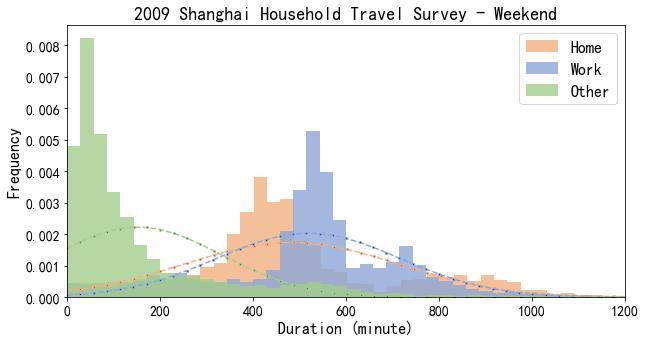

In [293]:
plt.figure(figsize=(10,5))
#plt.subplot(1,2,2)
# Home
mu_H, sigma_H = stop.loc[(stop.ifworkday=='双休日')&(stop.activity=='H'),'d2'].agg(['mean','std'])
n, bins, patchs = plt.hist(stop.loc[(stop.ifworkday=='双休日')&(stop.activity=='H'),'d2'],\
                           num_bins, normed=1, color=rgb(241,177,128), alpha=0.8,label='Home')
y_H = mpl.mlab.normpdf(bins,mu_H,sigma_H)
plt.plot(bins,y_H,color=rgb(241,177,128), linestyle='dashed', marker='o', markerfacecolor='r', markersize=2)

# Work
mu_W, sigma_W = stop.loc[(stop.ifworkday=='双休日')&(stop.activity=='W'),'d2'].agg(['mean','std'])
n, bins, patchs = plt.hist(stop.loc[(stop.ifworkday=='双休日')&(stop.activity=='W'),'d2'],\
                           num_bins, normed=1, color=rgb(141,167,215), alpha=0.8,label='Work')
y_W = mpl.mlab.normpdf(bins,mu_W,sigma_W)
plt.plot(bins,y_W,color=rgb(141,167,215), linestyle='dashed', marker='o', markerfacecolor='b', markersize=2)

# Other
mu_O, sigma_O = stop.loc[(stop.ifworkday=='双休日')&(stop.activity=='O'),'d2'].agg(['mean','std'])
n, bins, patchs = plt.hist(stop.loc[(stop.ifworkday=='双休日')&(stop.activity=='O'),'d2'],\
                           num_bins, normed=1, color=rgb(162,205,140), alpha=0.8,label='Other')
y_O = mpl.mlab.normpdf(bins,mu_O,sigma_O)
plt.plot(bins,y_O,color=rgb(162,205,140), linestyle='dashed', marker='o', markerfacecolor='g', markersize=2)

# axis
plt.xlim([0,1200])
plt.title('2009 Shanghai Household Travel Survey - Weekend',fontsize=18)
plt.xlabel('Duration (minute)',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)

plt.savefig('C:\\Users\Administrator\Desktop\z2.png',bbox_inches='tight',pad_inches=0,dpi=600)

### 离家距离

In [324]:
import geopy.distance
def distance(lon1,lat1,lon2,lat2):
    return geopy.distance.vincenty( (lat1,lon1), (lat2,lon2) ).km

In [342]:
stop = pd.merge(stop[['HomeID','PersonID','Slon','Slat','activity','ifworkday']], family[['HomeID','HomeCoor_X','HomeCoor_Y']],on='HomeID')
stop.dropna(inplace=True)
stop = stop[(stop.Slon>0) & (stop.Slat>0) & (stop.HomeCoor_X>0) & (stop.HomeCoor_Y>0)]
stop.reset_index(drop=True,inplace=True)

In [343]:
stop['distance'] = stop[['Slon','Slat','HomeCoor_X','HomeCoor_Y']].apply(lambda r: \
                            distance(r.Slon, r.Slat, r.HomeCoor_X, r.HomeCoor_Y), axis=1)

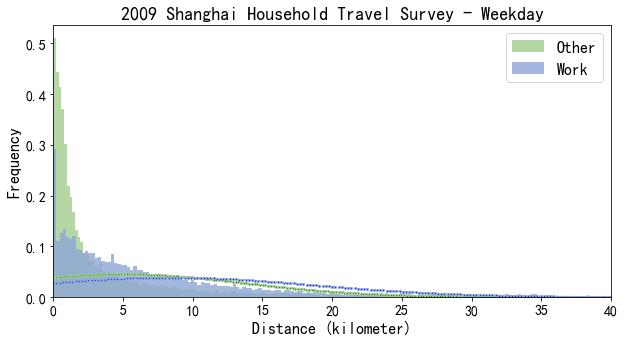

In [346]:
plt.figure(figsize=(10,5))
#plt.subplot(1,2,1)
num_bins = 500

# Other
mu_O, sigma_O = stop.loc[(stop.ifworkday=='工作日')&(stop.activity=='O'),'distance'].agg(['mean','std'])
n, bins, patchs = plt.hist(stop.loc[(stop.ifworkday=='工作日')&(stop.activity=='O'),'distance'],\
                           num_bins, normed=1, color=rgb(162,205,140), alpha=0.8,label='Other')
y_O = mpl.mlab.normpdf(bins,mu_O,sigma_O)
plt.plot(bins,y_O,color=rgb(162,205,140), linestyle='dashed', marker='o', markerfacecolor='g', markersize=2)


# Work
mu_W, sigma_W = stop.loc[(stop.ifworkday=='工作日')&(stop.activity=='W'),'distance'].agg(['mean','std'])
n, bins, patchs = plt.hist(stop.loc[(stop.ifworkday=='工作日')&(stop.activity=='W'),'distance'],\
                           num_bins, normed=1, color=rgb(141,167,215), alpha=0.8,label='Work')
y_W = mpl.mlab.normpdf(bins,mu_W,sigma_W)
plt.plot(bins,y_W,color=rgb(141,167,215), linestyle='dashed', marker='o', markerfacecolor='b', markersize=2)

# axis
plt.xlim([0,40])
plt.title('2009 Shanghai Household Travel Survey - Weekday',fontsize=18)
plt.xlabel('Distance (kilometer)',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=16)

plt.savefig('C:\\Users\Administrator\Desktop\z11.png',bbox_inches='tight',pad_inches=0,dpi=600)

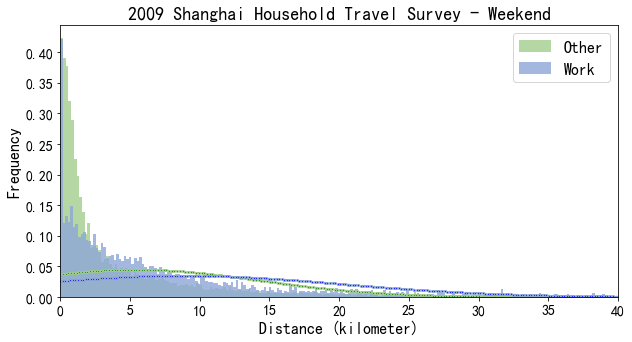

In [350]:
plt.figure(figsize=(10,5))
#plt.subplot(1,2,1)
num_bins = 500

# Other
mu_O, sigma_O = stop.loc[(stop.ifworkday=='双休日')&(stop.activity=='O'),'distance'].agg(['mean','std'])
n, bins, patchs = plt.hist(stop.loc[(stop.ifworkday=='双休日')&(stop.activity=='O'),'distance'],\
                           num_bins, normed=1, color=rgb(162,205,140), alpha=0.8,label='Other')
y_O = mpl.mlab.normpdf(bins,mu_O,sigma_O)
plt.plot(bins,y_O,color=rgb(162,205,140), linestyle='dashed', marker='o', markerfacecolor='g', markersize=2)

# axis
plt.xlim([0,40])
plt.title('2009 Shanghai Household Travel Survey - Weekend',fontsize=18)
plt.xlabel('Distance (kilometer)',fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Work
mu_W, sigma_W = stop.loc[(stop.ifworkday=='双休日')&(stop.activity=='W'),'distance'].agg(['mean','std'])
n, bins, patchs = plt.hist(stop.loc[(stop.ifworkday=='双休日')&(stop.activity=='W'),'distance'],\
                           num_bins, normed=1, color=rgb(141,167,215), alpha=0.8,label='Work')
y_W = mpl.mlab.normpdf(bins,mu_W,sigma_W)
plt.plot(bins,y_W,color=rgb(141,167,215), linestyle='dashed', marker='o', markerfacecolor='b', markersize=2)
plt.legend(fontsize=16)

plt.savefig('C:\\Users\Administrator\Desktop\z12.png',bbox_inches='tight',pad_inches=0,dpi=600)

In [197]:
# week: 调查星期
family_cols = ['HomeID','HomeCoor_X','HomeCoor_Y','week','Pnum','n_bike','n_ebike','n_moto','n_pcar','n_wcar','ifworkday']
family = pd.read_csv('./family.csv',usecols=family_cols)
family.sort_values('HomeID',inplace=True)

In [198]:
family.head()

,HomeID,HomeCoor_X,HomeCoor_Y,week,Pnum,n_bike,n_ebike,n_moto,n_pcar,n_wcar,ifworkday
0,1,121.467201,31.235452,5,2,1,0,2,0,0,1.工作日
1,2,121.467201,31.235452,5,3,0,2,1,0,0,1.工作日
2,3,121.021624,30.956375,5,1,0,1,0,0,0,1.工作日
3,4,121.122011,31.146839,5,5,1,1,0,1,1,1.工作日
4,5,121.103262,31.159090,6,3,1,1,0,0,0,2.双休日


In [ ]:
# 

In [202]:
trip[trip.PersonID == 45267]

,PersonID,HomeID,Stime,Etime,Tpurpose,Tmode,Tduration,Tweight,FROM_X,FROM_Y,TO_X,TO_Y
82800,45267,19188,08:00:00,08:30:00,W,2.助动车,30,158.48,121.499298,31.216662,121.473906,31.215002
82801,45267,19188,08:40:00,08:50:00,B,2.助动车,10,158.48,121.473906,31.215002,121.475107,31.227307
82802,45267,19188,09:20:00,09:35:00,W,2.助动车,15,158.48,121.475107,31.227307,121.473906,31.215002
82803,45267,19188,09:50:00,10:05:00,B,2.助动车,15,158.48,121.473906,31.215002,121.468435,31.224290
82804,45267,19188,10:20:00,10:30:00,W,2.助动车,10,158.48,121.468435,31.224290,121.473906,31.215002
82805,45267,19188,10:45:00,11:00:00,B,2.助动车,15,158.48,121.473906,31.215002,121.465244,31.221302
82806,45267,19188,11:20:00,11:35:00,W,2.助动车,15,158.48,121.465244,31.221302,121.473906,31.215002
82807,45267,19188,13:10:00,13:25:00,B,2.助动车,15,158.48,121.473906,31.215002,121.470752,31.225118
82808,45267,19188,13:45:00,14:00:00,W,2.助动车,15,158.48,121.470752,31.225118,121.473906,31.215002
82809,45267,19188,15:00:00,15:15:00,B,2.助动车,15,158.48,121.473906,31.215002,121.468835,31.224688


### 统计出行次数

In [216]:
trip_cnt = trip.groupby('PersonID').HomeID.count().reset_index()
trip_cnt.rename(columns={'HomeID':'cnt'},inplace=True)

2.3593738914508693


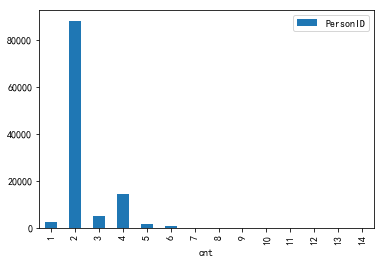

In [223]:
print(trip_cnt.cnt.mean())
trip_cnt.groupby('cnt').count().plot(kind='bar')